Before starting, you will need to install some packages to reproduce the baseline.

In [1]:
!pip install tqdm
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pathlib import Path
from tqdm import tqdm

import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [5]:
# import data
PATH_COLAB = '/content/drive/MyDrive/challenge_ens_2023_small/moco_features.zip'
PATH_DEVICE = '..'
try:
    from google.colab import drive
    logging.info('Working on Colab.')
    
    # connect your drive to the session
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/challenge_data_ens_small/

    # unzip data into the colab session
    ! unzip $PATH_COLAB -d /content
    logging.info('Data unziped in your Drive.')

    %cd /content

    %cp -R drive/MyDrive/challenge_ens_2023_small/supplementary_data/ .
    %cp drive/MyDrive/challenge_ens_2023_small/train_output.csv .


except:
    logging.info('Working on your device.')
    
    data_exists = os.path.exists(PATH_DEVICE + '/train_input') and os.path.exists(PATH_DEVICE + '/test_input') and os.path.exists(PATH_DEVICE + '/train_output.csv')
    
    if data_exists:
        logging.info(f"Dataset found on device at : '{PATH_DEVICE}.'") 
    else:
        raise FileNotFoundError(f"Data folder not found at '{PATH_DEVICE}'")

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/challenge_data_ens_small/'
/content
Archive:  /content/drive/MyDrive/challenge_ens_2023_small/moco_features.zip
  inflating: /content/test_input/.DS_Store  
   creating: /content/test_input/moco_features/
  inflating: /content/test_input/moco_features/ID_003.npy  
  inflating: /content/test_input/moco_features/ID_004.npy  
  inflating: /content/test_input/moco_features/ID_008.npy  
  inflating: /content/test_input/moco_features/ID_009.npy  
  inflating: /content/test_input/moco_features/ID_010.npy  
  inflating: /content/test_input/moco_features/ID_011.npy  
  inflating: /content/test_input/moco_features/ID_015.npy  
  inflating: /content/test_input/moco_features/ID_017.npy  
  inflating: /content/test_input/moco_features/ID_022.npy  
  inflating: /content/test_input/moco_features/ID_027.npy  
  inflating: /content/test_input/moco_features/ID_029.npy  
  inflating: /content/test_input/moco_features/I

# Data architecture

After downloading or unzipping the downloaded files, your data tree must have the following architecture in order to properly run the notebook:
```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


This notebook aims to reproduce the baseline method on this challenge called `MeanPool`. This method consists in a logistic regression learnt on top of tile-level MoCo V2 features averaged over the slides.

For a given slide $s$ with $N_s=1000$ tiles and corresponding MoCo V2 features $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$, a slide-level average is performed over the tile axis.

For $j=1,...,2048$:

$$\overline{\mathbf{k_s}}(j) = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathbf{K_s}(i, j) $$

Thus, the training input data for MeanPool consists of $S_{\text{train}}=344$ mean feature vectors $\mathbf{k_s}$, $s=1,...,S_{\text{train}}$, where $S_{\text{train}}$ denotes the number of training samples.

## Data loading

In [8]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("./")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [178]:
X_train_mean = []
X_train_max = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train_mean.append(np.mean(features, axis=0))
    X_train_max.append(np.max(features, axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train_mean = np.array(X_train_mean)
X_train_max = np.array(X_train_max)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:18<00:00, 18.46it/s]


In [179]:
X_test_mean = []
X_test_max = []
centers_test = []

# load the data from `df_test` (~ 1 minute)
for sample, center in tqdm(df_test[["Sample ID", "Center ID"]].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test_mean.append(np.mean(features, axis=0))
    X_test_max.append(np.max(features, axis=0))
    centers_test.append(center)

X_test_mean = np.array(X_test_mean)
X_test_max = np.array(X_test_max)
centers_test = np.array(centers_test)

100%|██████████| 149/149 [00:07<00:00, 20.80it/s]


In [180]:
from sklearn.decomposition import PCA


X_mean = np.concatenate([X_train_mean, X_test_mean])
X_max = np.concatenate([X_train_max, X_test_max])
centers = np.concatenate([centers_train, centers_test])


In [181]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

for center in np.unique(centers):
  scaler = QuantileTransformer(n_quantiles=20, output_distribution='normal')
  scaler.fit(X_mean[centers==center])

  X_max[centers==center] = scaler.transform(X_max[centers==center])
  X_mean[centers==center] = scaler.transform(X_mean[centers==center])


In [88]:
for center in np.unique(centers):
  mean = np.mean(X_mean[centers==center], axis=0)
  std = np.std(X_mean[centers==center], axis=0)
  X_max[centers==center] = (X_max[centers==center] - mean) / std
  X_mean[centers==center] = (X_mean[centers==center] - mean) / std

In [121]:
X_reduced = PCA(n_components=2).fit_transform(X_mean)

colors = np.array([int(x[-1]) for x in centers]) 

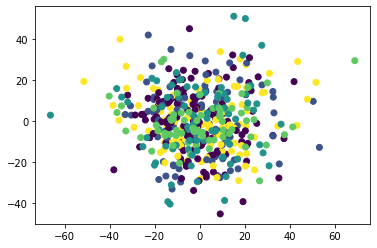

In [122]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=colors, label=colors)
plt.show()

In [182]:
X_train = X_mean[:len(X_train_mean)]
X_test = X_mean[len(X_train_mean):]

## 5-fold cross validation

In [183]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [184]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

aucs = []
lrs = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.0005, solver="liblinear")
        #lr = RandomForestClassifier(n_estimators=50, max_depth=5)
        #lr = AdaBoostClassifier()
        #lr = SVC(kernel = 'linear', C=0.0005, probability=True)
        #lr = KNeighborsClassifier(n_neighbors=7, weights='distance')
        #lr = GradientBoostingClassifier(n_estimators=100)
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

AUC on split 0 fold 0: 0.698
AUC on split 0 fold 1: 0.700
AUC on split 0 fold 2: 0.724
AUC on split 0 fold 3: 0.749
AUC on split 0 fold 4: 0.630
----------------------------
AUC on split 1 fold 0: 0.682
AUC on split 1 fold 1: 0.775
AUC on split 1 fold 2: 0.680
AUC on split 1 fold 3: 0.616
AUC on split 1 fold 4: 0.676
----------------------------
AUC on split 2 fold 0: 0.683
AUC on split 2 fold 1: 0.721
AUC on split 2 fold 2: 0.707
AUC on split 2 fold 3: 0.669
AUC on split 2 fold 4: 0.655
----------------------------
AUC on split 3 fold 0: 0.801
AUC on split 3 fold 1: 0.664
AUC on split 3 fold 2: 0.707
AUC on split 3 fold 3: 0.557
AUC on split 3 fold 4: 0.737
----------------------------
AUC on split 4 fold 0: 0.651
AUC on split 4 fold 1: 0.625
AUC on split 4 fold 2: 0.767
AUC on split 4 fold 3: 0.598
AUC on split 4 fold 4: 0.736
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.688 (0.056)


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [177]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

 31%|███       | 46/149 [00:02<00:06, 16.66it/s]


KeyboardInterrupt: ignored

## Inference

In [185]:
preds_test = 0
# loop over the classifiers
for lr in lrs:
    preds_test += lr.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(lrs)

## Saving predictions

In [186]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output_scaled_LogReg_0_0005.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.607028
1,ID_004.npy,0.604906
2,ID_008.npy,0.467746
3,ID_009.npy,0.253943
4,ID_010.npy,0.327380


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [ ]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 0
Test: 0
Total: 0



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [ ]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

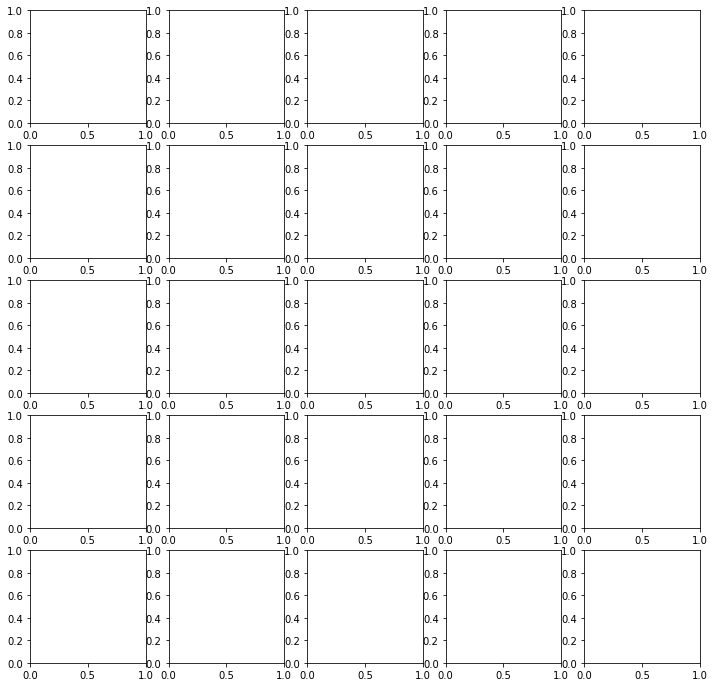

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [ ]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [ ]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



[]